# WiDS 2025
### Sex Patterns in ADHD

### Import

In [ ]:
import pandas as pd
import numpy as np
import math


from sklearn.compose import ColumnTransformer
from sklearn.linear_model import MultiTaskElasticNetCV, LogisticRegression, RidgeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_scorelo0
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


import seaborn as sns
import matplotlib.pyplot as plt

# Multi-output
from sklearn.multioutput import MultiOutputClassifier

# Multi-task
from sklearn.linear_model import MultiTaskElasticNetCV


In [47]:
source = "TRAIN"
connectome_train = pd.read_csv(f"{source}/{source}_FUNCTIONAL_CONNECTOME_MATRICES.csv")
cat_train = pd.read_csv(f"{source}/{source}_CATEGORICAL_METADATA.csv")
quan_train = pd.read_csv(f"{source}/{source}_QUANTITATIVE_METADATA.csv")
label = pd.read_csv(f"{source}/TRAINING_SOLUTIONS.csv")

In [3]:
source = "TEST"
connectome_test = pd.read_csv(f"{source}/{source}_FUNCTIONAL_CONNECTOME_MATRICES.csv")
cat_test = pd.read_csv(f"{source}/{source}_CATEGORICAL.csv")
quan_test = pd.read_csv(f"{source}/{source}_QUANTITATIVE_METADATA.csv")

In [4]:
train = cat_train.merge(quan_train, on= 'participant_id').merge(connectome_train, on= 'participant_id')
train.head(5)

test = connectome_train.merge(quan_test, on= 'participant_id').merge(cat_test, on= 'participant_id')


In [52]:
quan_train

,participant_id,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,UmrK0vMLopoR,40.00,13,3,10,47,13,11,28,0,6,1,5,0,5,1,0,10,NaN
1,CPaeQkhcjg7d,-94.47,14,3,13,34,18,23,30,0,18,6,8,7,8,10,4,5,NaN
2,Nb4EetVPm3gs,-46.67,14,4,10,35,16,10,29,1,14,2,8,5,7,6,4,9,8.239904
3,p4vPhVu91o4b,-26.68,10,5,12,39,19,16,28,6,24,4,16,9,10,8,4,6,NaN
4,M09PXs7arQ5E,0.00,14,5,15,40,20,24,28,1,18,4,11,4,10,7,3,9,8.940679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,Atx7oub96GXS,87.80,14,5,14,39,20,15,21,1,9,2,7,3,6,2,0,9,10.697923
1209,groSbUfkQngM,77.80,14,3,10,32,20,11,23,6,18,3,11,9,5,7,4,7,13.964750
1210,zmxGvIrOD0bt,16.68,14,3,16,28,15,19,27,3,4,1,3,0,0,1,0,10,NaN
1211,rOmWFuJCud5G,53.40,14,3,14,34,18,23,23,4,9,0,9,3,5,0,0,9,12.089094


In [5]:
train.set_index('participant_id',inplace=True)
test.set_index('participant_id',inplace=True)
label.set_index('participant_id',inplace=True)

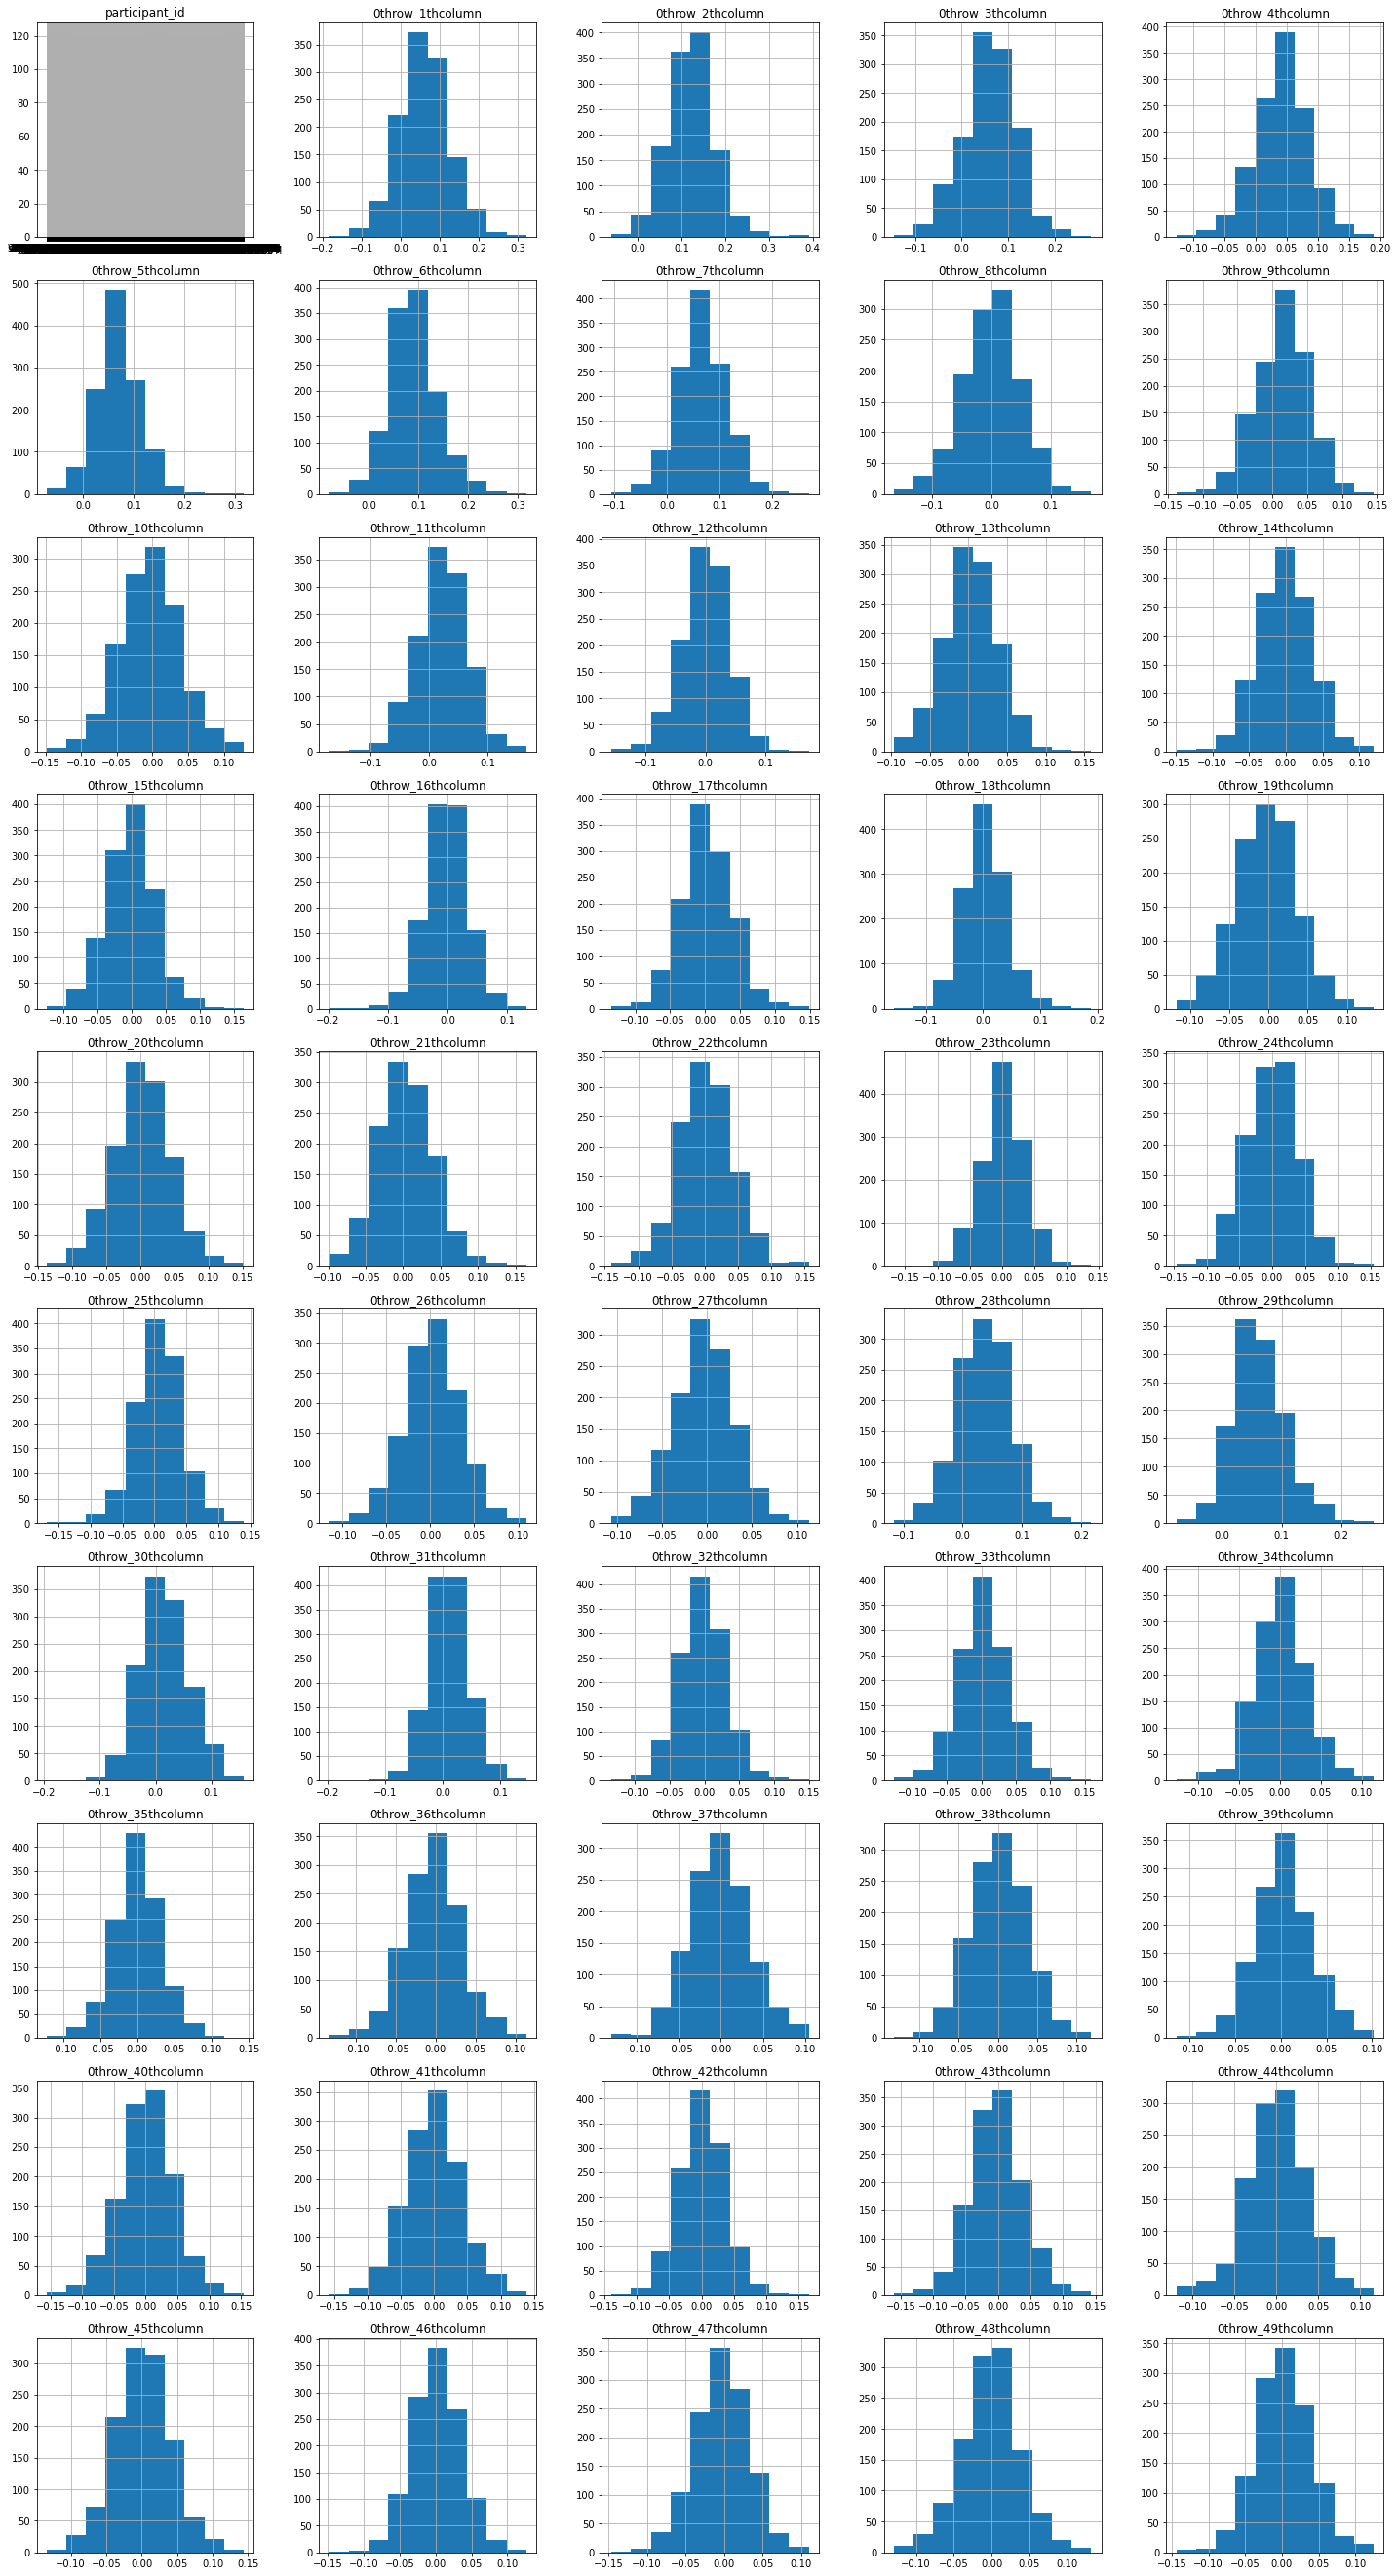

In [6]:
df = connectome_train.iloc[:, :50]

num_cols = df.shape[1]
num_rows = (num_cols + 4) // 5  # Calculate rows needed (5 columns per row)

fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4 * num_rows))  # Adjust figsize as needed

col_index = 0
for i in range(num_rows):
    for j in range(5):
        if col_index < num_cols:
            ax = axes[i, j] if num_rows > 1 else axes[j] # Handle single-row case
            df.iloc[:, col_index].hist(ax=ax)  # Plot histogram
            ax.set_title(df.columns[col_index])  # Set subplot title
            col_index += 1
        else:  # Hide unused subplots
            if num_rows > 1:
                axes[i, j].set_axis_off()
            else:
                axes[j].set_axis_off()
            

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()


In [7]:
# Explore Null data
pd.DataFrame(train.isnull().sum(), columns=['null_count']).query('null_count > 0')

,null_count
PreInt_Demos_Fam_Child_Ethnicity,11
MRI_Track_Age_at_Scan,360


In [8]:
# Filter out the row index of 
'''null_index = train[train.isnull().any(axis=1)].index

train = train[~train.index.isin(null_index)]
label = label[~label.index.isin(null_index)]'''

'null_index = train[train.isnull().any(axis=1)].index\n\ntrain = train[~train.index.isin(null_index)]\nlabel = label[~label.index.isin(null_index)]'

In [9]:
label.ADHD_Outcome.value_counts()
# 383 neg, 831 pos

ADHD_Outcome
1    831
0    382
Name: count, dtype: int64

In [10]:
label.Sex_F.value_counts()
# 797 M, 416 F

Sex_F
0    797
1    416
Name: count, dtype: int64

In [11]:
pd.crosstab(label['ADHD_Outcome'], label['Sex_F'], normalize='all')

Sex_F,0,1
ADHD_Outcome,,
0,0.178071,0.136851
1,0.478978,0.206101


In [12]:
pd.crosstab(label['ADHD_Outcome'], label['Sex_F'])

Sex_F,0,1
ADHD_Outcome,,
0,216,166
1,581,250


In [13]:
connectome_train.set_index('participant_id', inplace= True)

# Model Train
Baseline model: Multi-output pipeline for same model.
- Logistic Reg with L1 norm for sparsity and inference enhancement
- NN with 2 output nodes with binary classifier activiation function (Sigmoid)

Performance: Multi-task models with shared features for correlated tasks.
- Multitask Lasso or multitask Elastic Net

### Preprocessing
A pipeline that transform categorical into one-hot code, and quant data into a standard scaler

In [14]:
cat_train = cat_train.drop(['PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race'], axis =1 )
categorical_features = list(cat_train.drop(['participant_id'], axis= 1).columns)
numeric_features = train.drop(cat_train.drop(['participant_id'], axis = 1).columns, axis = 1).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [15]:
# Create ColumnTransformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Mean imputation for missing values
    ('scaler', StandardScaler())                 # Standard scaling
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

### Train - test split


In [37]:
x_train, x_test, y_train, y_test = train_test_split(train, label, test_size=0.3, random_state=527)


In [38]:
pd.DataFrame(x_train.isnull().sum(), columns=['null_count']).query('null_count > 0')

,null_count
PreInt_Demos_Fam_Child_Ethnicity,8
MRI_Track_Age_at_Scan,251


In [18]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(849, 19927)
(364, 19927)
(849, 2)
(364, 2)


### Visual call-out Functions

In [19]:
def model_result(y_test, y_pred, model_name):
    """
    Compute and display important performance metrics for a classification model, 
    including F1-score, sensitivity, specificity, and a confusion matrix heatmap.

    Parameters:
    -----------
    y_test : array-like or Series (Truth)
    y_pred : array-like or Series (Model prediction)
    model_name : str

    Outputs:
    --------
    - Prints the F1-score, sensitivity (recall), and specificity.
    - Displays a heatmap of the confusion matrix for easier interpretation.

    Usage:
    ------
    1. Pass `y_test` and `y_pred` as arrays (or pandas Series).
    2. Provide a descriptive `model_name`(model and dataset used) to label the confusion matrix plot.
    """
    classes = ['Negative', 'positive']
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Compute confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate sensitivity and specificity
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)

    # Print results
    print('Accuracy: ', accuracy)
    print(f"Sensitivity (Recall/True Positive Rate): {sens:.2f}")
    print(f"Specificity (True Negative Rate): {spec:.2f}")
    print('f1: ', f1_score(y_test, y_pred))

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix of {model_name}")
    plt.show()

### Logistic Regression for each task

In [20]:
# Create a new DataFrame with transformed data (optional)
#features_transformed = pd.DataFrame(transformed_data, columns=preprocessor.get_feature_names_out()).columns
#features_transformed#[features_transformed.str.contains("cat__|num__")]


In [39]:
train_ct = label.iloc[:,0].count()
train_female_ct = label[label.Sex_F == 1].count()[0]
train_male_ct = train_ct - train_female_ct

train_posADHD_ct = label[label.ADHD_Outcome == 1].count()[0]
train_negADHD_ct = train_ct - train_posADHD_ct

C:\Users\tuana\AppData\Local\Temp/ipykernel_27036/710916087.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_female_ct = label[label.Sex_F == 1].count()[0]
C:\Users\tuana\AppData\Local\Temp/ipykernel_27036/710916087.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_posADHD_ct = label[label.ADHD_Outcome == 1].count()[0]


Accuracy:  0.6978021978021978
Sensitivity (Recall/True Positive Rate): 0.43
Specificity (True Negative Rate): 0.84
f1:  0.5045045045045046


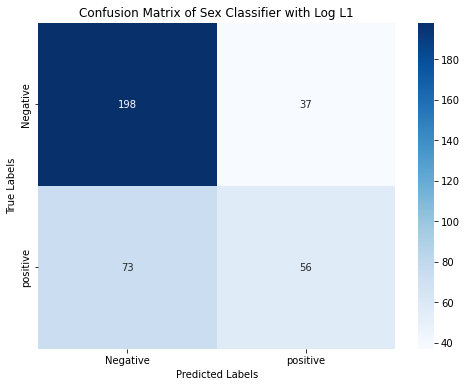

In [40]:
# Class weight for imbalance
weight_positive = train_ct / (2 * train_female_ct)
weight_negative = train_ct / (2 * train_male_ct)
sex_weights = {0: weight_negative, 1: weight_positive}


# Pipeline to preprocess, train using Log Regression with L1 Regularization
pipeline = Pipeline(steps=[
    ('classifier', (LogisticRegression(penalty='l1', solver='liblinear', class_weight= sex_weights)))
])
# Fit the preprocessor on training data
x_train_preprocessed = preprocessor.fit_transform(x_train)
x_train_features = pd.DataFrame(x_train_preprocessed, columns=preprocessor.get_feature_names_out()).columns

# Transform the test data using the same preprocessor
x_test_preprocessed = preprocessor.transform(x_test)
x_test_features = pd.DataFrame(x_test_preprocessed, columns=preprocessor.get_feature_names_out()).columns
pipeline.fit(x_train_preprocessed, y_train.iloc[:,1])

# Fit pipeline on preprocessed training data
log_reg = pipeline.named_steps['classifier']

log_reg.fit(x_train_preprocessed, y_train.iloc[:, 1])
# Predict on preprocessed test data
y_pred = log_reg.predict(x_test_preprocessed)

# Evaluate the model
model_result(y_test['Sex_F'], y_pred, "Sex Classifier with Log L1")

In [23]:
# Find elements in A not in B
values_not_in_b = [item for item in x_train_features if item not in x_test_features]
print("Values in A but not in B:", values_not_in_b)

Values in A but not in B: []


In [44]:
# Create a new DataFrame with transformed data (optional)
features_transformed = pd.DataFrame(x_test_preprocessed, columns=preprocessor.get_feature_names_out()).columns
#features_transformed#[features_transformed.str.contains("cat__|num__")]
coefficients = log_reg.coef_[0]  # Coefficients for the single task
feature_names = x_train.columns

# Combine coefficients with feature names
coef_data = list(zip(features_transformed, coefficients))
df = pd.DataFrame(coef_data, columns = ['connectome', 'coef'])
df.connectome = df.connectome.apply(lambda x: x.replace("cat__", "")).apply(lambda x: x.replace("num__", ""))
df['rank'] = df['coef'].apply(lambda x: abs(x)).rank(ascending = False)
df = df.set_index('connectome')
df[df.coef >= 0.1].sort_values('rank')

,coef,rank
connectome,,
SDQ_SDQ_Emotional_Problems,0.420734,1.0
55throw_98thcolumn,0.296380,5.0
150throw_191thcolumn,0.259010,8.0
34throw_65thcolumn,0.246021,11.0
64throw_115thcolumn,0.245910,12.0
...,...,...
82throw_86thcolumn,0.103666,148.0
148throw_175thcolumn,0.103106,149.0
94throw_141thcolumn,0.101074,153.0


Accuracy:  0.7692307692307693
Sensitivity (Recall/True Positive Rate): 0.82
Specificity (True Negative Rate): 0.67
f1:  0.8285714285714285


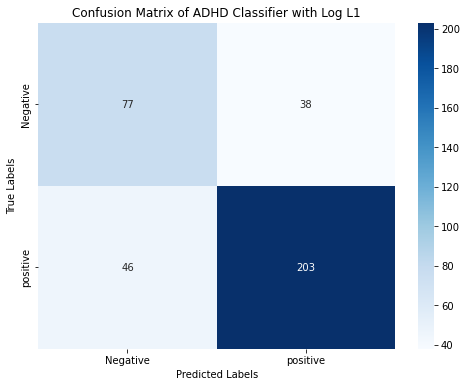

In [25]:
# Class weight for imbalance
total_samples = 382 + 831
weight_positive = total_samples / (2 * 831)
weight_negative = total_samples / (2 * 382)
class_weights = {0: weight_negative, 1: weight_positive}

log_reg = LogisticRegression(penalty='l1', solver='liblinear', class_weight= class_weights)
log_reg.fit(x_train_preprocessed, y_train.iloc[:, 0])
# Predict on preprocessed test data
y_pred = log_reg.predict(x_test_preprocessed)

# Evaluate the model
model_result(y_test['ADHD_Outcome'], y_pred, "ADHD Classifier with Log L1")

In [26]:
# Create a new DataFrame with transformed data (optional)
features_transformed = pd.DataFrame(x_test_preprocessed, columns=preprocessor.get_feature_names_out()).columns
#features_transformed#[features_transformed.str.contains("cat__|num__")]
coefficients = log_reg.coef_[0]  # Coefficients for the single task
feature_names = x_train.columns

# Combine coefficients with feature names
coef_data = list(zip(features_transformed, coefficients))
df = pd.DataFrame(coef_data, columns = ['connectome', 'coef'])
df.connectome = df.connectome.apply(lambda x: x.replace("cat__", "")).apply(lambda x: x.replace("num__", ""))
df['rank'] = df['coef'].apply(lambda x: abs(x)).rank(ascending = False)
df = df.set_index('connectome')
df.sort_values('rank')#.to_csv('ADHD coef_list.csv')

,coef,rank
connectome,,
SDQ_SDQ_Hyperactivity,2.364841,1.0
SDQ_SDQ_Generating_Impact,0.591363,2.0
0throw_6thcolumn,-0.439437,3.0
6throw_20thcolumn,-0.384138,4.0
159throw_167thcolumn,0.323136,5.0
...,...,...
37throw_61thcolumn,0.000000,10240.0
37throw_59thcolumn,0.000000,10240.0
37throw_58thcolumn,0.000000,10240.0


In [27]:
df[df.coef >= 0.1].sort_values('rank')

,coef,rank
connectome,,
SDQ_SDQ_Hyperactivity,2.364841,1.0
SDQ_SDQ_Generating_Impact,0.591363,2.0
159throw_167thcolumn,0.323136,5.0
18throw_199thcolumn,0.280199,8.0
162throw_175thcolumn,0.278288,9.0
62throw_69thcolumn,0.251598,13.0
95throw_190thcolumn,0.245616,16.0
67throw_187thcolumn,0.238583,18.0
50throw_185thcolumn,0.218985,19.0


# RandomForest Model for non-linear

In [28]:
# Define a pipeline for scaling and SMOTE

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Mean imputation for missing values
    ('scaler', StandardScaler())                 # Standard scaling
])
smote = SMOTE(sampling_strategy='auto', random_state=527)
x_train, x_test, y_train, y_test = train_test_split(connectome_train, label.iloc[:,1], test_size=0.3, random_state=527)

# Transform the test data using the same preprocessor
x_train_scaled = numeric_transformer.fit_transform(x_train)
x_test_scaled = numeric_transformer.transform(x_test) 

x_train_resampled, y_train_resampled= smote.fit_resample(x_train_scaled, np.array(y_train))


In [29]:
y_test

participant_id
yPqk7RmP36lu    0
S8a4pIeq9Ay6    1
vf1akUdbv0FE    1
kawulA88OFSQ    0
8Ro2MJOI8nC1    0
               ..
um0Awu6Rmi05    1
H9EU0xUEI4QX    1
04X1eiS79T4B    1
souZpvrxn6pq    1
KBGDu4oGa56e    1
Name: Sex_F, Length: 364, dtype: int64

Accuracy:  0.6126373626373627
Sensitivity (Recall/True Positive Rate): 0.03
Specificity (True Negative Rate): 0.93
f1:  0.053691275167785234


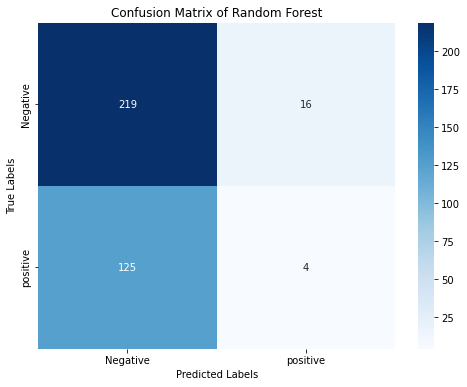

In [30]:
# Pipeline to preprocess, train using Log Regression with L1 Regularization
rf_base = RandomForestClassifier(
        n_estimators=100,   # Number of trees (adjust for performance)
        max_depth=None,     # Allow trees to grow deep (tune as needed)
        random_state=42,    # For reproducibility
        n_jobs=-1           # Use all available CPU cores
    )


rf_base.fit(x_train_resampled, y_train_resampled)

# Predict on test data
y_pred = rf_base.predict(x_test_scaled)

# Evaluate the model
model_result(y_test, y_pred, "Random Forest")

In [31]:
connectome_train.iloc[:20,]

,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,0throw_10thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
participant_id,,,,,,,,,,,,,,,,,,,,,
70z8Q2xdTXM3,0.093473,0.146902,0.067893,0.015141,0.070221,0.063997,0.055382,-0.035335,0.068583,0.029271,...,0.003404,-0.010359,-0.050968,-0.014365,0.128066,0.112646,-0.058980,0.028228,0.133582,0.143372
WHWymJu6zNZi,0.029580,0.179323,0.112933,0.038291,0.104899,0.064250,0.008488,0.077505,-0.004750,-0.035073,...,-0.008409,-0.008479,0.020891,0.017754,0.094040,0.035141,0.032537,0.075007,0.115350,0.138200
4PAQp1M6EyAo,-0.051580,0.139734,0.068295,0.046991,0.111085,0.026978,0.151377,0.021198,0.083721,-0.014275,...,0.053245,-0.028003,0.028773,0.024556,0.166343,0.058925,0.035485,0.063661,0.042862,0.162162
obEacy4Of68I,0.016273,0.204702,0.115980,0.043103,0.056431,0.057615,0.055773,0.075030,0.001033,-0.064031,...,-0.023918,-0.005356,0.018607,0.016193,0.072955,0.130135,0.056120,0.084784,0.114148,0.190584
s7WzzDcmDOhF,0.065771,0.098714,0.097604,0.112988,0.071139,0.085607,0.019392,-0.036403,-0.020375,0.005426,...,0.066439,-0.076680,-0.047530,-0.031443,0.221213,0.007343,0.005763,0.083820,0.079582,0.067269
s55ZRHrJtnlL,0.097002,0.177220,0.157997,0.014924,0.072341,0.089639,0.095062,0.030083,0.032561,0.035393,...,-0.030121,-0.135468,-0.085999,-0.063705,0.040591,0.000316,-0.014827,0.097217,0.147553,0.215787
sId1cQF5F22m,0.045489,0.080887,0.073523,0.051792,0.024821,0.083677,0.094708,-0.140014,0.082289,-0.018601,...,-0.000073,-0.062791,0.006491,0.032897,0.072081,-0.016697,-0.069584,0.025494,-0.065204,0.143606
T4CaImRntWnB,0.063175,0.043360,0.096523,0.070671,0.126199,0.048935,0.099142,0.081876,-0.052236,0.043440,...,0.052967,-0.077304,-0.029844,0.038803,0.013027,0.073547,0.015062,0.120607,0.169392,0.136079
a5JFxSZjVg5i,0.093676,0.024290,0.107459,-0.028266,0.187952,0.167986,0.036723,0.045456,-0.029576,0.077269,...,-0.004193,0.011555,-0.080249,-0.036657,0.221324,0.072227,0.026967,0.054274,-0.028924,0.112389


In [32]:
df = connectome_train.iloc[:,:20].copy()
scaler = StandardScaler()
columns = [df.columns]
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns= columns)
df_scaled.index = label.index

In [33]:
merged_df = pd.merge(df_scaled, label['Sex_F'], left_index= True, right_index= True)
merged_df

,"(0throw_1thcolumn,)","(0throw_2thcolumn,)","(0throw_3thcolumn,)","(0throw_4thcolumn,)","(0throw_5thcolumn,)","(0throw_6thcolumn,)","(0throw_7thcolumn,)","(0throw_8thcolumn,)","(0throw_9thcolumn,)","(0throw_10thcolumn,)",...,"(0throw_12thcolumn,)","(0throw_13thcolumn,)","(0throw_14thcolumn,)","(0throw_15thcolumn,)","(0throw_16thcolumn,)","(0throw_17thcolumn,)","(0throw_18thcolumn,)","(0throw_19thcolumn,)","(0throw_20thcolumn,)",Sex_F
participant_id,,,,,,,,,,,,,,,,,,,,,
UmrK0vMLopoR,0.513163,0.455298,0.132672,-0.601418,0.011285,-0.549326,-0.244857,-0.725885,1.425930,0.758274,...,1.229858,-0.941031,-0.386402,0.397633,0.415886,-0.209349,0.444602,-0.999854,0.271287,1
CPaeQkhcjg7d,-0.482805,1.055647,0.916378,-0.068908,0.795796,-0.544179,-1.245913,1.575747,-0.494339,-0.757687,...,-2.295651,-0.909181,0.465500,-1.850333,-0.602272,-2.136961,0.804683,2.641402,1.360246,0
Nb4EetVPm3gs,-1.747919,0.322559,0.139674,0.131208,0.935717,-1.302215,1.804368,0.427232,1.822317,-0.267675,...,-1.285407,0.891830,0.175579,0.837835,0.107474,0.029522,-0.030308,0.451594,2.099689,0
p4vPhVu91o4b,-0.690225,1.525580,0.969392,0.041769,-0.300670,-0.679128,-0.236513,1.525255,-0.342918,-1.439925,...,-0.654748,0.151227,0.303477,0.451641,0.465770,-0.919809,-1.522971,-0.463166,0.063269,1
M09PXs7arQ5E,0.081337,-0.437023,0.649650,1.649333,0.032059,-0.109827,-1.013147,-0.747660,-0.903485,0.196498,...,-0.118872,0.286735,-0.322727,-0.975815,0.629202,1.056282,-0.424888,-0.912512,0.556337,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Atx7oub96GXS,-0.586430,-1.805154,-1.162006,-0.465038,0.534850,-0.155348,-1.192475,0.725854,0.256109,-0.183015,...,-0.805763,-0.102764,-0.260785,-0.013183,0.511084,-0.886739,0.077496,-0.847360,-1.309223,0
groSbUfkQngM,-0.210046,0.252585,1.463315,0.314025,-0.089631,0.458473,-0.730750,0.511909,-0.059710,-0.300596,...,1.297697,-1.322712,0.034770,-0.551422,-0.307877,-1.644514,0.641590,-0.901285,-0.290549,1
zmxGvIrOD0bt,0.529808,0.425252,0.029513,-0.246706,0.193550,0.302022,-0.488178,0.793303,0.468625,-0.360121,...,-1.298286,1.815878,-0.001216,-0.353045,1.342312,0.046311,0.169666,0.373255,0.148917,1


# XGBoost

In [34]:
xgb_classifier = XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5)

xgb_classifier.fit(x_train_resampled, y_train_resampled)

# Predict on test data
y_pred = xgb_classifier.predict(x_test_scaled)

# Evaluate the model
model_result(y_test, y_pred, "Random Forest")

KeyboardInterrupt: 